# To Do:

- Explain the HCS regime $C_v$ for Disks, why is it 1?

- Explain the sub-HCS regime $C_v$ for Disks, what is due to the pressure?

- Check position and momentum equipartition!

- Is there no pressure in the HCS regime?

- Repeat for RB

- Overlay $\phi_B$ and / or $\phi_T$

- Measure the effective potential for RB

- Measure the effective modes for RB

In [1]:
import pydpmd as dp
from pydpmd.plot import draw_particles_frame, create_animation, downsample, draw_circle
from pydpmd.utils import split_systems, join_systems
import matplotlib.pyplot as plt
import numpy as np
import os
from mode_resources import *
from system_building_resources import *
import subprocess
import h5py
from collections import defaultdict
from correlation_functions import compute_stress_acf, compute_einstein_helfand_stress_acf
from scipy.interpolate import make_smoothing_spline
import pandas as pd
from matplotlib.colors import LogNorm

In [2]:
temperature_range_hcs = np.linspace(1e-12, 5e-12, 100)
# temperature_range_hcs = np.linspace(1e-5, 5e-5, 100)
delta_phi_hcs_range = [1e-2, 1e-3, 1e-4, -1e-4, -1e-3, -1e-2]
temperature_range = np.linspace(1e-5, 5e-5, 100)
delta_phi_range = [-1e-3, -1e-2, -1e-1, -2e-1, -3e-1, -4e-1]
root = '/home/mmccraw/dev/data/11-01-25/'

# Disk

Here, we measure the specific heat $C_v$ for Disks in 2D.  We do this primarily by starting with $M$ distinct jammed configurations of $N=100$ particles.  We then create $D_\phi D_T$ duplicates of each configuration, at $D_T$ different temperatures and $D_\phi$ different densities below jamming $\Delta \phi=\phi_J-\phi$.  We then allow the systems to run in NVE, using the initial temperature to set the total energy since we start from a 0-overlap configuration (decompressing from jamming).  The temperatures are chosen to be in a tightly spaced range around some set value in the hard particle limit ($T~10^{-5}$).  Then, for a given system at a given $\Delta \phi$, we measure the slope of the total energy $E(T)$ due to the temperature change, across all the temperature values.  This gives us the specific heat $C_v=\partial_T E$.

# $\phi<\phi_{HCS}$

In [117]:
data = dp.data.load(os.path.join(root, 'jamming/disk-large/jamming/'), location=["final", "init"])
# data = dp.data.load(os.path.join(root, 'jamming/disk/jamming/'), location=["final", "init"])
del data.final.arrays['hessian_xx'], data.final.arrays['hessian_xy'], data.final.arrays['hessian_yx'], data.final.arrays['hessian_yy'], data.final.arrays['pair_dist'], data.final.arrays['pair_forces'], data.final.arrays['pair_ids']

data_new = []

temp_list = []
dphi_list = []
sid_list = []
for temperature in temperature_range:
    for delta_phi in delta_phi_range:
        temp_list.extend(np.ones(data.n_systems()) * temperature)
        dphi_list.extend(np.ones(data.n_systems()) * delta_phi)
        sid_list.extend(np.arange(data.n_systems()))
        data_new.append(data)

data_new = join_systems(data_new)
data_new.add_array(np.array(temp_list), 'target_temp')
data_new.add_array(np.array(dphi_list), 'delta_phi')
data_new.add_array(np.array(sid_list), 'original_system_id')
data_new.set_velocities(temp_list, np.random.randint(0, 1e9))
data_new.scale_to_packing_fraction(np.array(dphi_list) + data_new.packing_fraction)

dynamics_path = os.path.join(root, 'dynamics')
data_new.set_neighbor_method(NeighborMethod.Cell)
set_standard_cell_list_parameters(data_new, 0.3)
data_new.save(dynamics_path)

n_steps = 1e5
save_freq = 1e2
dt = 1e-2

subprocess.run([
    os.path.join("/home/mmccraw/dev/dpmd/build/", "nve_disk_pbc_final"),
    dynamics_path,
    dynamics_path,
    str(n_steps),
    str(save_freq),
    str(dt),
], check=True)

Running for 100000 steps
Step 0
Step 10000
Step 20000
Step 30000
Step 40000
Step 50000
Step 60000
Step 70000
Step 80000
Step 90000
Done


CompletedProcess(args=['/home/mmccraw/dev/dpmd/build/nve_disk_pbc_final', '/home/mmccraw/dev/data/11-01-25/dynamics', '/home/mmccraw/dev/data/11-01-25/dynamics', '100000.0', '100.0', '0.01'], returncode=0)

In [118]:
final = dp.data.load(dynamics_path, location=['final', 'init'], load_trajectory=True)
disp = np.mean(np.sum((final.trajectory.pos.copy() - final.trajectory[0].pos) ** 2, axis=-1), axis=0)
rmsd = np.sqrt(np.add.reduceat(disp, final.system_offset[:-1]) / final.system_size)

Loading trajectory:   0%|          | 0/7 [00:00<?, ?it/s]

Loading trajectory: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]


There are four ways to get the specific heat:

1) By exactly calculating the quantity $C_v=\partial_T \langle E \rangle$ - measuring the slope of the total energy as a function of the temperature for a system in NVE initialized at various $T$.
2) A continuation of method 1 wherein $E=K+\Phi$ is inserted, equipartition is assumed, and $C_v$ is immediately related to the slope of the potential $\partial_T \langle \Phi \rangle$ and the number of degrees of freedom.  $C_v=\frac{d}{2}+\partial_T \langle \Phi \rangle$
3) Yet a further extension of method 1 wherein the analytical derivative is related to the fluctuations in $\Phi$.  $C_v=\frac{d}{2}+\frac{1}{N k_B^2 T^2} var(\Phi)$
4) The Leibowitz-Percus-Verlet (LPV) theorem which is used only for NVE.  $C_v=\frac{d}{2}[1-\frac{N d}{2} \frac{var(K)}{\langle K \rangle^2}]^{-1}$

To understand the form of the variance approaches, notice that the temperature derivative of the energy is really just the variance of the energy.  In other words, $C_v=var(E)=var(K)+var(\Phi)$.  These are applicable in NVT where the total energy fluctuates.  Since in NVE, the total energy is fixed, these are not applicable unless in the thermodynamic limit.  Since we use moderately sized systems, we can obtain such an equivalence.

The benefit of the latter two approaches is that they can be computed for a single run and do not require calculating a numerical derivative.  However, they require more careful treatment of the fluctuations and can be sensitive to issues with equilibration / short-term equipartition violations as can be seen when the density approaches jamming $\Delta \phi \to 0$ or $\phi \to \phi_J$.  This will be demonstrated in the next plot.

In [ ]:
ke = final.trajectory.ke_total.copy()
pe = final.trajectory.pe_total.copy()
te = ke + pe
pressure = final.trajectory.pressure.copy()

t0 = 200

N = final.system_size
d = 2
N_dof = d * (N - 1)  # com is fixed

# <K>=NdkT/2
temp = 2 * np.mean(ke[t0:], axis=0) / N_dof

ke_fluc = np.var(ke[t0:], axis=0) / np.mean(ke[t0:], axis=0) ** 2

norm = plt.Normalize(vmin=0, vmax=np.unique(final.original_system_id).size)
phi_norm = LogNorm(vmin=np.abs(final.delta_phi).min(), vmax=np.abs(final.delta_phi).max())
cmap = plt.cm.viridis

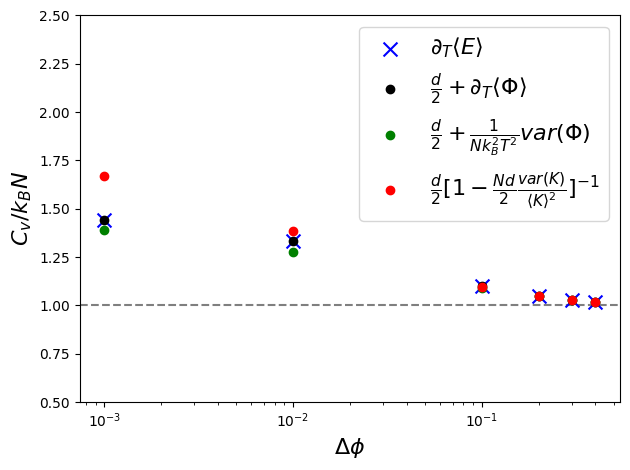

In [ ]:
for sid in np.unique(final.original_system_id):
    mask = final.original_system_id == sid
    for delta_phi in np.unique(final.delta_phi):
        mask2 = (final.delta_phi == delta_phi) & (mask)
        T = temp[mask2]


        te_N = np.mean(te[t0:, mask2] / (N[mask2] - 1), axis=0)
        pe_N = np.mean(pe[t0:, mask2] / (N[mask2] - 1), axis=0)
        te_N = te_N[np.argsort(T)]
        pe_N = pe_N[np.argsort(T)]
        T = T[np.argsort(T)]


        T_fit = np.linspace(min(T), max(T), 100)
        C_v, b = np.polyfit(T, te_N, 1)
        C_v_pe, b_pe = np.polyfit(T, pe_N, 1)


        lpv_factor = (1 - ke_fluc[mask2] * (N_dof[mask2] / 2)) ** -1
        C_v_lpv = d / 2 * lpv_factor
        C_v_var_pe = d / 2 + np.var(pe[t0:, mask2], axis=0) / temp[mask2] ** 2 / (N[mask2] - 1)
    
        plt.scatter(-delta_phi, C_v, c='b', marker='x', s=100)
        plt.scatter(-delta_phi, d/2 + C_v_pe, c='k')
        plt.scatter(-delta_phi, np.mean(C_v_var_pe), c='g')
        plt.scatter(-delta_phi, np.mean(C_v_lpv), c='r')
    break

plt.scatter([], [], c='b', marker='x', s=100, label=r'$\partial_T \langle E \rangle$')
plt.scatter([], [], c='k', label=r'$\frac{d}{2}+\partial_T \langle \Phi \rangle$')
plt.scatter([], [], c='g', label=r'$\frac{d}{2}+\frac{1}{N k_B^2 T^2} var(\Phi)$')
plt.scatter([], [], c='r', label=r'$\frac{d}{2}[1-\frac{N d}{2} \frac{var(K)}{\langle K \rangle^2}]^{-1}$')
plt.legend(fontsize=16)

plt.axhline(1, linestyle='--', alpha=0.5, color='k', zorder=0)

plt.xscale('log')
# plt.yscale('log')
plt.ylim(0.5, 2.5)
plt.ylabel(r'$C_v/k_B N$', fontsize=16)
plt.xlabel(r'$\Delta \phi$', fontsize=16)
plt.tight_layout()
if not os.path.exists('figures/heat-capacity-disk'):
    os.makedirs('figures/heat-capacity-disk')
plt.savefig('figures/heat-capacity-disk/different-methods.png', dpi=600)

As can be seen below, the fluctuations in the two single-run approaches for calculating the specific heat ($C_v=\frac{d}{2}+\frac{1}{N k_B^2 T^2} var(\Phi)$ and $C_v=\frac{d}{2}[1-\frac{N d}{2} \frac{var(K)}{\langle K \rangle^2}]^{-1}$) are extreme when the density approaches jamming $\Delta \phi \to 0$ (we would expect $C_v(T)$ to be a smooth line in this regime).  This is because the system can be trapped in longer-lived metastable states, throwing off the ensemble average approximated from the time average.

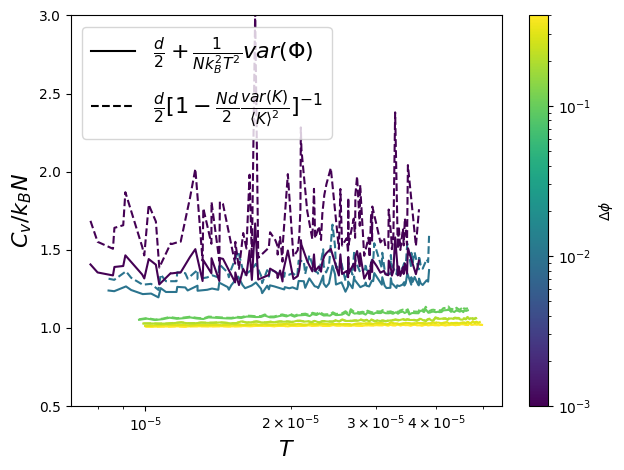

In [128]:
for sid in np.unique(final.original_system_id):
    mask = final.original_system_id == sid
    for delta_phi in np.unique(final.delta_phi):
        mask2 = (final.delta_phi == delta_phi) & (mask)
        T = temp[mask2]


        te_N = np.mean(te[t0:, mask2] / (N[mask2] - 1), axis=0)
        pe_N = np.mean(pe[t0:, mask2] / (N[mask2] - 1), axis=0)
        te_N = te_N[np.argsort(T)]
        pe_N = pe_N[np.argsort(T)]
        T = T[np.argsort(T)]


        T_fit = np.linspace(min(T), max(T), 100)
        C_v, b = np.polyfit(T, te_N, 1)
        C_v_pe, b_pe = np.polyfit(T, pe_N, 1)


        lpv_factor = (1 - ke_fluc[mask2] * (N_dof[mask2] / 2)) ** -1
        C_v_lpv = d / 2 * lpv_factor
        C_v_var_pe = d / 2 + np.var(pe[t0:, mask2], axis=0) / temp[mask2] ** 2 / (N[mask2] - 1)

        plt.plot(T, C_v_var_pe, c=cmap(phi_norm(abs(delta_phi))))
        plt.plot(T, C_v_lpv, c=cmap(phi_norm(abs(delta_phi))), linestyle='--')
    break
plt.xscale('log')
# plt.yscale('log')
plt.ylim(0.5, 3)
plt.ylabel(r'$C_v/k_B N$', fontsize=16)
plt.xlabel(r'$T$', fontsize=16)

plt.plot([], [], c='k', label=r'$\frac{d}{2}+\frac{1}{N k_B^2 T^2} var(\Phi)$')
plt.plot([], [], c='k', linestyle='--', label=r'$\frac{d}{2}[1-\frac{N d}{2} \frac{var(K)}{\langle K \rangle^2}]^{-1}$')
plt.legend(fontsize=16)

sm = plt.cm.ScalarMappable(norm=phi_norm, cmap=cmap)
sm.set_array(np.abs(final.delta_phi))
cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\Delta \phi$')

plt.tight_layout()
plt.savefig('figures/heat-capacity-disk/fluctuation-methods.png', dpi=600)

# $\phi>\phi_{HCS}$

In [131]:
data = dp.data.load(os.path.join(root, 'jamming/disk/jamming/'), location=["final", "init"])

H_list, M_list, val_list, vec_list, non_rattler_id_list = get_dynamical_matrix_modes_for_disk(data, 3, True)
del data.final.arrays['hessian_xx'], data.final.arrays['hessian_xy'], data.final.arrays['hessian_yx'], data.final.arrays['hessian_yy'], data.final.arrays['pair_dist'], data.final.arrays['pair_forces'], data.final.arrays['pair_ids']

data_new = []

for sid, d in enumerate(split_systems(data)):
    vec = vec_list[sid]
    non_rattler_ids = non_rattler_id_list[sid]
    N = len(non_rattler_ids)

    pos = d.final.pos[non_rattler_ids].copy()
    rad = d.rad[non_rattler_ids].copy()
    box_size = d.final.box_size.copy()
    mass = d.mass[non_rattler_ids].copy()
    vec_all = np.sum(vec[:, 2:], axis=1)
    vel = np.column_stack((vec_all[:N], vec_all[N:]))

    for temperature in temperature_range_hcs:
        for delta_phi in delta_phi_hcs_range:
            scale = np.sqrt(temperature / (np.sum(mass * np.sum(vel ** 2, axis=1)) / (N - 1)))

            sys_new = build_disk_system_from_radii(rad, 'small', 0.1)
            sys_new.pos = pos
            sys_new.rad = rad
            sys_new.mass = mass
            sys_new.box_size = box_size
            sys_new.vel = vel * scale
            sys_new.e_interaction = d.e_interaction

            sys_new.calculate_packing_fraction()
            sys_new.scale_to_packing_fraction(sys_new.packing_fraction + delta_phi)

            sys_new.add_array(np.array([sid]), 'original_system_id')
            sys_new.add_array(np.array([delta_phi]), 'delta_phi')
            sys_new.add_array(np.array([temperature]), 'target_temp')
            data_new.append(sys_new)

data_new = join_systems(data_new)

dynamics_hcs_path = os.path.join(root, 'dynamics_hcs')
data_new.set_neighbor_method(NeighborMethod.Cell)
set_standard_cell_list_parameters(data_new, 0.3)
data_new.save(dynamics_hcs_path)

n_steps = 1e5
save_freq = 1e2
dt = 1e-2

subprocess.run([
    os.path.join("/home/mmccraw/dev/dpmd/build/", "nve_disk_pbc_final"),
    dynamics_hcs_path,
    dynamics_hcs_path,
    str(n_steps),
    str(save_freq),
    str(dt),
], check=True)

100%|██████████| 100/100 [00:00<00:00, 283.17it/s]


Running for 100000 steps
Step 0
Step 10000
Step 20000
Step 30000
Step 40000
Step 50000
Step 60000
Step 70000
Step 80000
Step 90000
Done


CompletedProcess(args=['/home/mmccraw/dev/dpmd/build/nve_disk_pbc_final', '/home/mmccraw/dev/data/11-01-25/dynamics_hcs', '/home/mmccraw/dev/data/11-01-25/dynamics_hcs', '100000.0', '100.0', '0.01'], returncode=0)

In [132]:
dynamics_hcs_path = os.path.join(root, 'dynamics_hcs')
final = dp.data.load(dynamics_hcs_path, location=['final', 'init'], load_trajectory=True)
disp = np.mean(np.sum((final.trajectory.pos.copy() - final.trajectory[0].pos) ** 2, axis=-1), axis=0)
rmsd = np.sqrt(np.add.reduceat(disp, final.system_offset[:-1]) / final.system_size)

Loading trajectory:   0%|          | 0/7 [00:00<?, ?it/s]

Loading trajectory: 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]


Here, we run the same protocol, but we use smaller systems with $N=10$ particles for better clarity.  We also first remove the rattlers from each configuration and set the initial temperature to be a weighted sum of all of the eigenvectors of the dynamical matrix.  Note that after the rattler removal, $N\leq10$!  This is the standard procedure for clearly analyzing the properties of the hypocoordinated solid (HCS) regime (using fewer particles makes it easier to do this since rearrangements are less likely).  We then compress and overcompress the systems both above and below jamming.  In either case, there are two distinct trends.  Some systems remain stuck in the HCS regime, stuck in metastable harmonic basins - and others eventually break out of this regime and effectively sample a set of such basins.

When a system is stuck in a metastable basin, the dynamics can be analytically determined be treating the system of $N$ particles in $d$ dimensions as a set of $Nd$ harmonic oscillators.  In this case, both $K$ and $\Phi$ contribute $Nd k_B T/2$ to the total energy, which gives $C_v/k_B N=d=2$.  We find this result with the slope method and nearly also with the LPV method.  However, the NVT result does not work because the correspondence with the NVT fails in this regime.

In the freely moving systems, we easily capture the expected result of $C_v/k_B N=d/2=1$.

In [133]:
ke = final.trajectory.ke_total.copy()
pe = final.trajectory.pe_total.copy()
te = ke + pe
pressure = final.trajectory.pressure.copy()

t0 = 200

N = final.system_size
d = 2
N_dof = d * (N - 1)  # com is fixed

# <K>=NdkT/2
temp = 2 * np.mean(ke[t0:], axis=0) / N_dof

ke_fluc = np.var(ke[t0:], axis=0) / np.mean(ke[t0:], axis=0) ** 2

norm = plt.Normalize(vmin=0, vmax=np.unique(final.original_system_id).size)
cmap = plt.cm.viridis

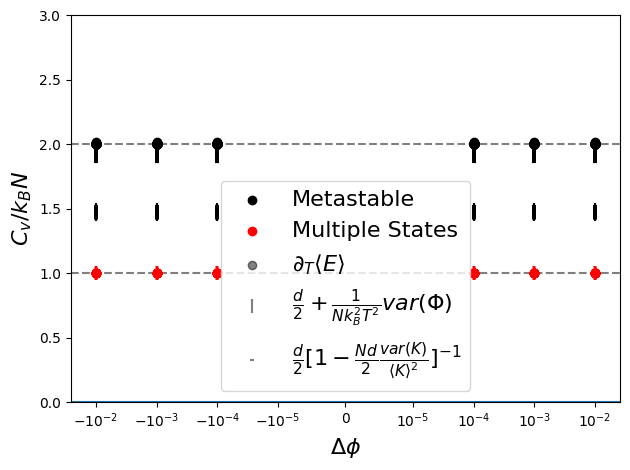

In [ ]:
vals = []

for sid in np.unique(final.original_system_id):
    mask = final.original_system_id == sid
    for delta_phi in np.unique(final.delta_phi):
        mask2 = (final.delta_phi == delta_phi) & (mask)
        T = temp[mask2]


        te_N = np.mean(te[t0:, mask2] / (N[mask2] - 1), axis=0)
        pe_N = np.mean(pe[t0:, mask2] / (N[mask2] - 1), axis=0)
        te_N = te_N[np.argsort(T)]
        pe_N = pe_N[np.argsort(T)]
        T = T[np.argsort(T)]


        T_fit = np.linspace(min(T), max(T), 100)
        C_v, b = np.polyfit(T, te_N, 1)
        C_v_pe, b_pe = np.polyfit(T, pe_N, 1)


        lpv_factor = (1 - ke_fluc[mask2] * (N_dof[mask2] / 2)) ** -1
        C_v_lpv = d / 2 * lpv_factor
        C_v_var_pe = d / 2 + np.var(pe[t0:, mask2], axis=0) / temp[mask2] ** 2 / (N[mask2] - 1)

        plt.scatter(-delta_phi, C_v, c='r' if np.mean(rmsd[mask2]) > 1e-4 else 'k')
        plt.scatter(-delta_phi, np.mean(C_v_var_pe), c='r' if np.mean(rmsd[mask2]) > 1e-4 else 'k', marker='|', s=100)
        plt.scatter(-delta_phi, np.mean(C_v_lpv), c='r' if np.mean(rmsd[mask2]) > 1e-4 else 'k', marker='_', s=10)

        vals.append(np.mean(C_v_lpv) / C_v)
# plt.xscale('log')
# plt.yscale('log')
plt.ylim(0, 3)
plt.xscale('symlog', linthresh=1e-5)
plt.ylabel(r'$C_v/k_B N$', fontsize=16)
plt.xlabel(r'$\Delta \phi$', fontsize=16)

plt.scatter([], [], c='k', label='Metastable')
plt.scatter([], [], c='r', label='Multiple States')
plt.scatter([], [], c='k', alpha=0.5, label=r'$\partial_T \langle E \rangle$')
plt.scatter([], [], c='k', alpha=0.5, marker='|', s=100, label=r'$\frac{d}{2}+\frac{1}{N k_B^2 T^2} var(\Phi)$')
plt.scatter([], [], c='k', alpha=0.5, marker='_', s=10, label=r'$\frac{d}{2}[1-\frac{N d}{2} \frac{var(K)}{\langle K \rangle^2}]^{-1}$')

plt.legend(fontsize=16)

plt.axhline(2, zorder=0, linestyle='--', c='k', alpha=0.5)
plt.axhline(1, zorder=0, linestyle='--', c='k', alpha=0.5)

plt.tight_layout()
plt.savefig('figures/heat-capacity-disk/hcs-plots.png', dpi=600)

# RB

In [3]:
rb_root = '/home/mmccraw/dev/data/11-06-25'

# $\phi>\phi_{HCS}$

In [166]:
ptype = os.path.join('N-10', '5-0.50')
rb_dynamics_hcs_path = os.path.join(root, 'rb_hcs', ptype)
ptype_root = os.path.join(rb_root, 'jamming', ptype)
for p in os.listdir(ptype_root):
    data = dp.data.load(os.path.join(ptype_root, p), location=['final', 'init'])
    H_list, M_list, val_list, vec_list, non_rattler_id_list = get_dynamical_matrix_modes_for_rigid_bumpy(data, 4, True)    
    for fname in ['friction_coeff', 'hessian_tt', 'hessian_tx', 'hessian_ty', 'hessian_xt', 'hessian_xx', 'hessian_xy', 'hessian_yt', 'hessian_yx', 'hessian_yy', 'pair_forces', 'pair_ids', 'pair_vertex_contacts']:
        del data.final.arrays[fname]
    break

100%|██████████| 10/10 [00:00<00:00, 486.11it/s]


### Method 1 - Standard

In [182]:
data_new = []
dphi_list = []
temp_list = []
scale_list = []
sid_list = []

for sid, d in enumerate(split_systems(data)):
    vec = vec_list[sid].copy()
    val = val_list[sid].copy()
    non_rattler_ids = non_rattler_id_list[sid]
    N = len(non_rattler_ids)

    pos = d.final.pos[non_rattler_ids].copy()
    box_size = d.final.box_size.copy()
    angle = d.final.angle[non_rattler_ids].copy()
    rad = d.rad[non_rattler_ids].copy()
    mass = d.mass[non_rattler_ids].copy()
    moment_inertia = d.moment_inertia[non_rattler_ids].copy()
    vec_all = np.sum(vec[:, val > 0][:, get_eimask(val[val > 0])], axis=1)
    vel = np.column_stack((vec_all[:N], vec_all[N:2*N]))
    angle_vel = vec_all[2*N:]

    vertex_nr_mask = np.isin(d.vertex_particle_id, non_rattler_ids)

    vertex_pos = d.final.vertex_pos[vertex_nr_mask].copy()
    nv = d.n_vertices_per_particle[non_rattler_ids].copy()
    particle_offset = np.concatenate(([0], np.cumsum(nv)))
    vertex_particle_id = np.concatenate([np.ones(_nv, dtype=int) * i for i, _nv in enumerate(nv)])
    vertex_rad = d.vertex_rad[vertex_nr_mask].copy()
    vertex_mass = d.vertex_mass[vertex_nr_mask].copy()

    sys_new = RigidBumpy()
    sys_new.using_core = True
    sys_new.allocate_particles(nv.size)
    sys_new.allocate_systems(1)
    sys_new.allocate_vertices(nv.sum())
    sys_new.n_vertices_per_particle = nv
    sys_new.particle_offset = particle_offset
    sys_new.set_ids()
    sys_new.pos = pos
    sys_new.box_size = box_size
    sys_new.angle = angle
    sys_new.rad = rad
    sys_new.mass = mass
    sys_new.moment_inertia = moment_inertia
    sys_new.vel = vel
    sys_new.angular_vel = angle_vel
    sys_new.vertex_rad = vertex_rad
    sys_new.vertex_pos = vertex_pos
    sys_new.vertex_mass = vertex_mass
    sys_new.e_interaction = d.e_interaction
    sys_new.validate()
    sys_new.calculate_packing_fraction()

    for temperature in temperature_range_hcs:
        scale = np.sqrt(temperature / (2 * np.sum(mass * np.sum(vel ** 2, axis=1) + moment_inertia * angle_vel ** 2) / (3 * (N - 2))))
        for delta_phi in delta_phi_hcs_range:
            scale_list.append(scale)
            dphi_list.append(delta_phi)
            temp_list.append(temperature)
            sid_list.append(sid)
            data_new.append(sys_new)

scale_list = np.array(scale_list)
dphi_list = np.array(dphi_list)
temp_list = np.array(temp_list)
sid_list = np.array(sid_list)

data_new = join_systems(data_new)
data_new.calculate_packing_fraction()
data_new.scale_to_packing_fraction(data_new.packing_fraction + dphi_list)
data_new.add_array(sid_list, 'original_system_id')
data_new.add_array(dphi_list, 'delta_phi')
data_new.add_array(temp_list, 'target_temp')

data_new.vel *= scale_list[data_new.system_id][:, None]
data_new.angular_vel *= scale_list[data_new.system_id]

In [ ]:
data_new.set_neighbor_method(NeighborMethod.Cell)
set_standard_cell_list_parameters(data_new, 0.3)
data_new.save(rb_dynamics_hcs_path)

n_steps = 1e5
save_freq = 1e2
dt = 1e-2

subprocess.run([
    os.path.join("/home/mmccraw/dev/dpmd/build/", "nve_rigid_bumpy_pbc_final"),
    rb_dynamics_hcs_path,
    rb_dynamics_hcs_path,
    str(n_steps),
    str(save_freq),
    str(dt),
], check=True)

Running for 100000 steps
Step 0
Step 10000
Step 20000
Step 30000
Step 40000
Step 50000
Step 60000
Step 70000
Step 80000
Step 90000
Done


CompletedProcess(args=['/home/mmccraw/dev/dpmd/build/nve_rigid_bumpy_pbc_final', '/home/mmccraw/dev/data/11-01-25/rb_hcs/N-10/5-0.50', '/home/mmccraw/dev/data/11-01-25/rb_hcs/N-10/5-0.50', '100000.0', '100.0', '0.01'], returncode=0)

#### Method 2 - Minimize after compression

In [187]:
data_new = []
dphi_list = []
temp_list = []
scale_list = []
sid_list = []
vel_list = []
angle_vel_list = []

for sid, d in enumerate(split_systems(data)):
    vec = vec_list[sid].copy()
    val = val_list[sid].copy()
    non_rattler_ids = non_rattler_id_list[sid]
    N = len(non_rattler_ids)

    pos = d.final.pos[non_rattler_ids].copy()
    box_size = d.final.box_size.copy()
    angle = d.final.angle[non_rattler_ids].copy()
    rad = d.rad[non_rattler_ids].copy()
    mass = d.mass[non_rattler_ids].copy()
    moment_inertia = d.moment_inertia[non_rattler_ids].copy()
    vec_all = np.sum(vec[:, val > 0][:, get_eimask(val[val > 0])], axis=1)
    vel = np.column_stack((vec_all[:N], vec_all[N:2*N]))
    angle_vel = vec_all[2*N:]

    vertex_nr_mask = np.isin(d.vertex_particle_id, non_rattler_ids)

    vertex_pos = d.final.vertex_pos[vertex_nr_mask].copy()
    nv = d.n_vertices_per_particle[non_rattler_ids].copy()
    particle_offset = np.concatenate(([0], np.cumsum(nv)))
    vertex_particle_id = np.concatenate([np.ones(_nv, dtype=int) * i for i, _nv in enumerate(nv)])
    vertex_rad = d.vertex_rad[vertex_nr_mask].copy()
    vertex_mass = d.vertex_mass[vertex_nr_mask].copy()

    sys_new = RigidBumpy()
    sys_new.using_core = True
    sys_new.allocate_particles(nv.size)
    sys_new.allocate_systems(1)
    sys_new.allocate_vertices(nv.sum())
    sys_new.n_vertices_per_particle = nv
    sys_new.particle_offset = particle_offset
    sys_new.set_ids()
    sys_new.pos = pos
    sys_new.box_size = box_size
    sys_new.angle = angle
    sys_new.rad = rad
    sys_new.mass = mass
    sys_new.moment_inertia = moment_inertia
    sys_new.vel = vel
    sys_new.angular_vel = angle_vel
    sys_new.vertex_rad = vertex_rad
    sys_new.vertex_pos = vertex_pos
    sys_new.vertex_mass = vertex_mass
    sys_new.e_interaction = d.e_interaction
    sys_new.validate()
    sys_new.calculate_packing_fraction()

    for delta_phi in delta_phi_hcs_range:
        dphi_list.append(delta_phi)
        sid_list.append(sid)
        data_new.append(sys_new)
        angle_vel_list.append(angle_vel)
        vel_list.append(vel)

dphi_list = np.array(dphi_list)
sid_list = np.array(sid_list)

data_new = join_systems(data_new)
data_new.calculate_packing_fraction()
data_new.scale_to_packing_fraction(data_new.packing_fraction + dphi_list)
data_new.add_array(sid_list, 'original_system_id')
data_new.add_array(dphi_list, 'delta_phi')

data_new.vel *= 0
data_new.angular_vel *= 0

data_new.set_neighbor_method(NeighborMethod.Cell)
set_standard_cell_list_parameters(data_new, 0.3)
data_new.save(rb_dynamics_hcs_path)
subprocess.run([
    os.path.join("/home/mmccraw/dev/dpmd/build/", "rigid_bumpy_equilibrate_pbc"),
    rb_dynamics_hcs_path,
    rb_dynamics_hcs_path,
], check=True)

data_new = dp.data.load(rb_dynamics_hcs_path, location=['final', 'init'])

V = np.concatenate(vel_list)
W = np.concatenate(angle_vel_list)
ke = np.add.reduceat(data_new.mass * np.sum(V ** 2, axis=-1) + data_new.moment_inertia * W ** 2, data_new.system_offset[:-1])

data_new.vel = V
data_new.angular_vel = W

data_list = []
scale_list = []
for temperature in temperature_range_hcs:
    scale_list.append(np.sqrt(temperature / (2 * ke) / (3 * (data_new.system_size - 2)))[data_new.system_id])
    data_list.append(data_new)
data_new = join_systems(data_list)
data_new.vel *= np.concatenate(scale_list)[:, None]
data_new.angular_vel *= np.concatenate(scale_list)

Minimizing
Did not converge in 1000000 steps
Done


In [188]:
data_new.set_neighbor_method(NeighborMethod.Cell)
set_standard_cell_list_parameters(data_new, 0.3)
data_new.save(rb_dynamics_hcs_path)

n_steps = 1e5
save_freq = 1e2
dt = 1e-2

subprocess.run([
    os.path.join("/home/mmccraw/dev/dpmd/build/", "nve_rigid_bumpy_pbc_final"),
    rb_dynamics_hcs_path,
    rb_dynamics_hcs_path,
    str(n_steps),
    str(save_freq),
    str(dt),
], check=True)

Running for 100000 steps
Step 0
Step 10000
Step 20000
Step 30000
Step 40000
Step 50000
Step 60000
Step 70000
Step 80000
Step 90000
Done


CompletedProcess(args=['/home/mmccraw/dev/dpmd/build/nve_rigid_bumpy_pbc_final', '/home/mmccraw/dev/data/11-01-25/rb_hcs/N-10/5-0.50', '/home/mmccraw/dev/data/11-01-25/rb_hcs/N-10/5-0.50', '100000.0', '100.0', '0.01'], returncode=0)

In [189]:
final = dp.data.load(rb_dynamics_hcs_path, location=['final', 'init'], load_trajectory=True)

disp = np.mean(np.sum((final.trajectory.pos.copy() - final.trajectory[0].pos) ** 2, axis=-1), axis=0)
rmsd = np.sqrt(np.add.reduceat(disp, final.system_offset[:-1]) / final.system_size)

Loading trajectory:  11%|█         | 1/9 [00:00<00:00,  8.74it/s]

Loading trajectory: 100%|██████████| 9/9 [00:00<00:00, 12.19it/s]


In [193]:
ke = final.trajectory.ke_total.copy()
pe = final.trajectory.pe_total.copy()
te = ke + pe
pressure = final.trajectory.pressure.copy()

t0 = 200
tf = -1

# t0 = 0
# tf = 200

N = final.system_size
d = 3
N_dof = d * (N - 1)  # com is fixed

# <K>=NdkT/2
temp = 2 * np.mean(ke[t0:tf], axis=0) / N_dof

ke_fluc = np.var(ke[t0:tf], axis=0) / np.mean(ke[t0:tf], axis=0) ** 2

norm = plt.Normalize(vmin=0, vmax=np.unique(final.original_system_id).size)
phi_norm = LogNorm(vmin=np.abs(final.delta_phi).min(), vmax=np.abs(final.delta_phi).max())
cmap = plt.cm.viridis

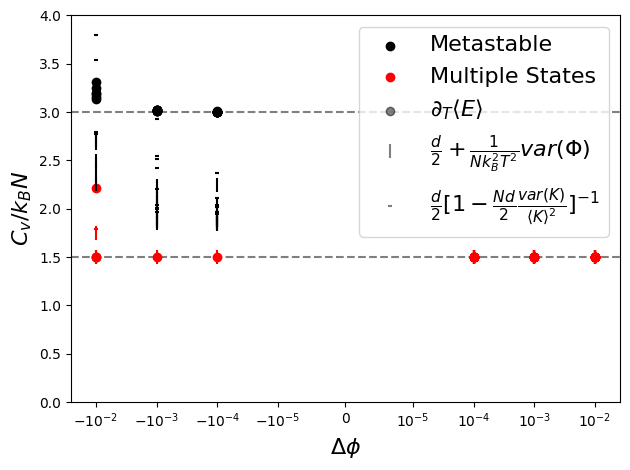

In [194]:
metastable_cutoff = 1e-6

for sid in np.unique(final.original_system_id):
    mask = final.original_system_id == sid
    for delta_phi in np.unique(final.delta_phi):
        mask2 = (final.delta_phi == delta_phi) & (mask)
        T = temp[mask2]


        te_N = np.mean(te[t0:tf, mask2] / (N[mask2] - 1), axis=0)
        pe_N = np.mean(pe[t0:tf, mask2] / (N[mask2] - 1), axis=0)
        te_N = te_N[np.argsort(T)]
        pe_N = pe_N[np.argsort(T)]
        T = T[np.argsort(T)]


        T_fit = np.linspace(min(T), max(T), 100)
        C_v, b = np.polyfit(T, te_N, 1)
        C_v_pe, b_pe = np.polyfit(T, pe_N, 1)


        lpv_factor = (1 - ke_fluc[mask2] * (N_dof[mask2] / 2)) ** -1
        C_v_lpv = d / 2 * lpv_factor
        C_v_var_pe = d / 2 + np.var(pe[t0:tf, mask2], axis=0) / temp[mask2] ** 2 / (N[mask2] - 1)

        plt.scatter(-delta_phi, C_v, c='r' if np.mean(rmsd[mask2]) > metastable_cutoff else 'k')
        plt.scatter(-delta_phi, np.mean(C_v_var_pe), c='r' if np.mean(rmsd[mask2]) > metastable_cutoff else 'k', marker='|', s=100)
        plt.scatter(-delta_phi, np.mean(C_v_lpv), c='r' if np.mean(rmsd[mask2]) > metastable_cutoff else 'k', marker='_', s=10)
# plt.xscale('log')
# plt.yscale('log')
plt.ylim(0, 4)
plt.xscale('symlog', linthresh=1e-5)
plt.ylabel(r'$C_v/k_B N$', fontsize=16)
plt.xlabel(r'$\Delta \phi$', fontsize=16)

plt.scatter([], [], c='k', label='Metastable')
plt.scatter([], [], c='r', label='Multiple States')
plt.scatter([], [], c='k', alpha=0.5, label=r'$\partial_T \langle E \rangle$')
plt.scatter([], [], c='k', alpha=0.5, marker='|', s=100, label=r'$\frac{d}{2}+\frac{1}{N k_B^2 T^2} var(\Phi)$')
plt.scatter([], [], c='k', alpha=0.5, marker='_', s=10, label=r'$\frac{d}{2}[1-\frac{N d}{2} \frac{var(K)}{\langle K \rangle^2}]^{-1}$')

plt.legend(fontsize=16)

plt.axhline(d, zorder=0, linestyle='--', c='k', alpha=0.5)
plt.axhline(d / 2, zorder=0, linestyle='--', c='k', alpha=0.5)

plt.tight_layout()
plt.savefig('figures/heat-capacity-rb/hcs-plots.png', dpi=600)

# $\phi<\phi_{HCS}$

In [216]:
ptype = os.path.join('N-10', '5-0.50')
rb_dynamics_path = os.path.join(root, 'rb', ptype)
ptype_root = os.path.join(rb_root, 'jamming', ptype)
for p in os.listdir(ptype_root):
    data = dp.data.load(os.path.join(ptype_root, p), location=['final', 'init'])
    H_list, M_list, val_list, vec_list, non_rattler_id_list = get_dynamical_matrix_modes_for_rigid_bumpy(data, 4, True)    
    for fname in ['friction_coeff', 'hessian_tt', 'hessian_tx', 'hessian_ty', 'hessian_xt', 'hessian_xx', 'hessian_xy', 'hessian_yt', 'hessian_yx', 'hessian_yy', 'pair_forces', 'pair_ids', 'pair_vertex_contacts']:
        del data.final.arrays[fname]
    break

data_new = []
temp_list = []
dphi_list = []
sid_list = []
for temperature in temperature_range:
    for delta_phi in delta_phi_range:
        temp_list.extend(np.ones(data.n_systems()) * temperature)
        dphi_list.extend(np.ones(data.n_systems()) * delta_phi)
        sid_list.extend(np.arange(data.n_systems()))
        data_new.append(data)

data_new = join_systems(data_new)
data_new.add_array(np.array(temp_list), 'target_temp')
data_new.add_array(np.array(dphi_list), 'delta_phi')
data_new.add_array(np.array(sid_list), 'original_system_id')
data_new.set_velocities(temp_list, np.random.randint(0, 1e9))
data_new.scale_to_packing_fraction(np.array(dphi_list) + data_new.packing_fraction)

data_new.set_neighbor_method(NeighborMethod.Cell)
set_standard_cell_list_parameters(data_new, 0.3)
data_new.save(rb_dynamics_path)

n_steps = 1e5
save_freq = 1e2
dt = 1e-2

subprocess.run([
    os.path.join("/home/mmccraw/dev/dpmd/build/", "nve_rigid_bumpy_pbc_final"),
    rb_dynamics_path,
    rb_dynamics_path,
    str(n_steps),
    str(save_freq),
    str(dt),
], check=True)

100%|██████████| 10/10 [00:00<00:00, 552.03it/s]


Running for 100000 steps
Step 0
Step 10000
Step 20000
Step 30000
Step 40000
Step 50000
Step 60000
Step 70000
Step 80000
Step 90000
Done


CompletedProcess(args=['/home/mmccraw/dev/dpmd/build/nve_rigid_bumpy_pbc_final', '/home/mmccraw/dev/data/11-01-25/rb/N-10/5-0.50', '/home/mmccraw/dev/data/11-01-25/rb/N-10/5-0.50', '100000.0', '100.0', '0.01'], returncode=0)

In [217]:
final = dp.data.load(rb_dynamics_path, location=['final', 'init'], load_trajectory=True)

In [218]:
ke = final.trajectory.ke_total.copy()
pe = final.trajectory.pe_total.copy()
te = ke + pe

t0 = 200

N = final.system_size
d = 3
N_dof = d * (N - 1)  # com is fixed

# <K>=NdkT/2
temp = 2 * np.mean(ke[t0:], axis=0) / N_dof

ke_fluc = np.var(ke[t0:], axis=0) / np.mean(ke[t0:], axis=0) ** 2

norm = plt.Normalize(vmin=0, vmax=np.unique(final.original_system_id).size)
phi_norm = LogNorm(vmin=np.abs(final.delta_phi).min(), vmax=np.abs(final.delta_phi).max())
cmap = plt.cm.viridis

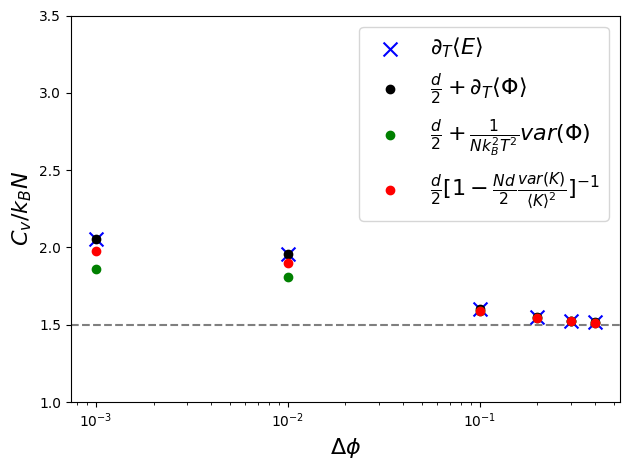

In [219]:
for sid in np.unique(final.original_system_id):
    mask = final.original_system_id == sid
    for delta_phi in np.unique(final.delta_phi):
        mask2 = (final.delta_phi == delta_phi) & (mask)
        T = temp[mask2]


        te_N = np.mean(te[t0:, mask2] / (N[mask2] - 1), axis=0)
        pe_N = np.mean(pe[t0:, mask2] / (N[mask2] - 1), axis=0)
        te_N = te_N[np.argsort(T)]
        pe_N = pe_N[np.argsort(T)]
        T = T[np.argsort(T)]


        T_fit = np.linspace(min(T), max(T), 100)
        C_v, b = np.polyfit(T, te_N, 1)
        C_v_pe, b_pe = np.polyfit(T, pe_N, 1)


        lpv_factor = (1 - ke_fluc[mask2] * (N_dof[mask2] / 2)) ** -1
        C_v_lpv = d / 2 * lpv_factor
        C_v_var_pe = d / 2 + np.var(pe[t0:, mask2], axis=0) / temp[mask2] ** 2 / (N[mask2] - 1)
    
        plt.scatter(-delta_phi, C_v, c='b', marker='x', s=100)
        plt.scatter(-delta_phi, d/2 + C_v_pe, c='k')
        plt.scatter(-delta_phi, np.mean(C_v_var_pe), c='g')
        plt.scatter(-delta_phi, np.mean(C_v_lpv), c='r')
    break

plt.scatter([], [], c='b', marker='x', s=100, label=r'$\partial_T \langle E \rangle$')
plt.scatter([], [], c='k', label=r'$\frac{d}{2}+\partial_T \langle \Phi \rangle$')
plt.scatter([], [], c='g', label=r'$\frac{d}{2}+\frac{1}{N k_B^2 T^2} var(\Phi)$')
plt.scatter([], [], c='r', label=r'$\frac{d}{2}[1-\frac{N d}{2} \frac{var(K)}{\langle K \rangle^2}]^{-1}$')
plt.legend(fontsize=16)

plt.axhline(d/2, linestyle='--', alpha=0.5, color='k', zorder=0)

plt.xscale('log')
# plt.yscale('log')
plt.ylim(1.0, 3.5)
plt.ylabel(r'$C_v/k_B N$', fontsize=16)
plt.xlabel(r'$\Delta \phi$', fontsize=16)
plt.tight_layout()


In [ ]:
desired_frames = 100
steps_to_animate = downsample(final, desired_frames)

output_path = "anim.gif"

# Create the animation using the downsampled steps
create_animation(
    update_func=draw_particles_frame,
    frames=steps_to_animate,
    filename=output_path,
    fps=15,
    bitrate=3000,
    data=final,
    system_id=np.argmax(rmsd),
    use_pbc=True,
    which='particle',
    cmap_name='grey',
    id_scale=1.1
)